# <center>Projet Tableau de bord : la Coupe du Monde 2022 au Qatar</center>
## <center>Présentation des résultats</center>

In [40]:
import pandas as pd
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import re
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import pyLDAvis
import pyLDAvis.gensim
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

In [108]:
path = 'C:\\Users\\Etudiant\\data\\'
df_articles = pd.DataFrame.from_csv(path + '2019-03-19_articles_clean.csv', sep=';')
df_articles.head(3)

C:\Users\Etudiant\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


,source,url,date,theme,title,subtitle,content,abo,content_type
0,Courrier International,https://www.courrierinternational.com/article/...,17/08/2015,"sport, suisse, courrier international paris","football, sepp, blatter, diffuser, portrait, a...","president, federation_internationale, football...","deuxla, aimaient, beaucoup, rivalite, joseph_b...",non,article
1,Courrier International,https://www.courrierinternational.com/article/...,29/01/2015,"sport, paysbas, courrier international paris","fifa, michael, van, praag, candidature, vouee,...","neerlandais, michael, van, praag, dernier, can...","devenir, president, fifa, faut, vouloir, titre...",non,article
2,Courrier International,https://www.courrierinternational.com/article/...,13/11/2014,"sport, qatar, royaumeuni, russie, courrier...","football, fifa, rapport, lattribution, mondial...","rapport, enquete, soupcons, corruption, concer...","rapport, devait, permettre, connaitre, verite,...",non,article


## 1. Quelques statistiques

#### Nombre d'articles

In [42]:
print('%s articles' % "{:,}".format(len(df_articles)))

2,944 articles


#### Source

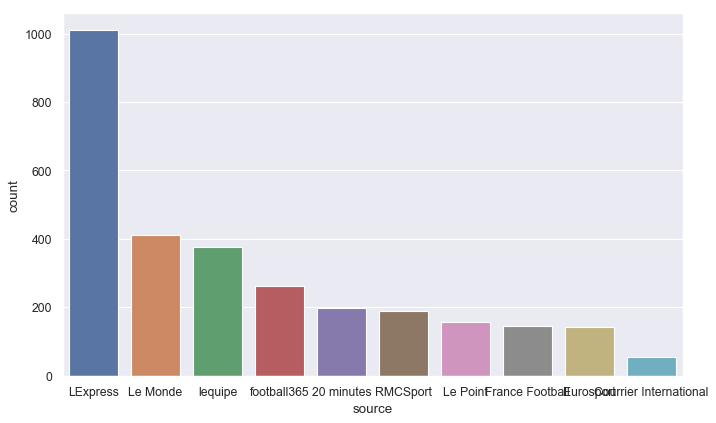

In [43]:
plt.figure(figsize = (10, 6), dpi = 80)
sns.set(style = 'darkgrid')
ax = sns.countplot(x = 'source', data = df_articles, order = df_articles['source'].value_counts().index)

#### Année

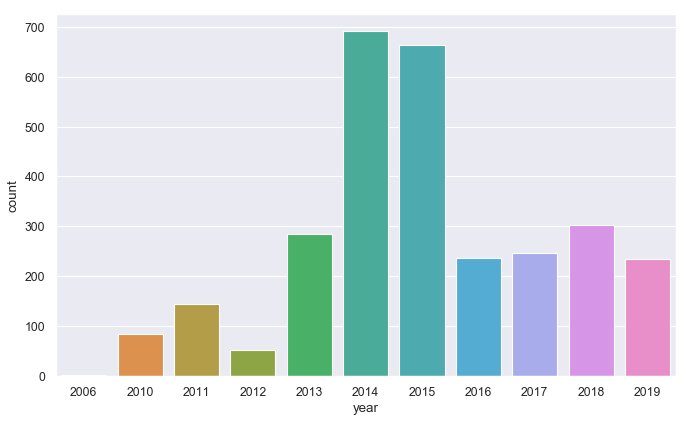

In [44]:
years = [0]*len(df_articles)
for k in range(len(df_articles)):
    years[k] = df_articles['date'][k][6:11]
    
df_articles['year'] = years
plt.figure(figsize = (10, 6), dpi = 80)
sns.set(style = 'darkgrid')
ax = sns.countplot(x = 'year', data = df_articles)

Le nombre important d'articles publiés en 2014 et 2015 coïncide avec 2 grands débats sur la Coupe du Monde 2022 : 
<li>Les <b>conditions de travail sur les chantiers</b> : à partir de fin 2013, des enquêtes ont été ouvertes sur les conditions de travail des ouvriers, et plusieurs scandales liés à des décès sur les chantiers ont alimenté des débats houleux ;</li>
<li>Les <b>dates de la Coupe du Monde</b> : en considérant les fortes chaleurs en été au Qatar (près de 50 °C avec un taux d'humidité de 80 % en juin), les organisateurs ont évoqué à partir de fin 2013 l'idée de jouer la Coupe du Monde 2022 en hiver. Cette décision a été actée en mars 2015.</li>

## 2. Mots et bigrams les plus fréquents

In [45]:
# Ajouter une liste de stopwords
path = 'C:\\Users\\Etudiant\\data\\'
df_new_stops = pd.DataFrame.from_csv(path + 'new_stops.csv', sep=';')
new_stops = df_new_stops['new_stops'].values.tolist()

C:\Users\Etudiant\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
dict_ = [] # Transformer la liste des contenus en dictionnaire

for k in range(len(df_articles)):
    dict_.append(df_articles.loc[k]['content'])
    
dict_ = str(dict_).strip('[]')
dict_ = dict_.replace("'", "")
dict_ = dict_.split(',')

# Compter les occurrences des mots
c = Counter(dict_)

In [62]:
def most_common(c, type_, nb):
    if type_ == 'words':
        df = pd.DataFrame(columns = ['words', 'nb_occur'])
        
        for word, nb_occur in c.most_common(nb):
            if word not in new_stops:
                L = df.shape[0]
                df.loc[L+1] = [word, nb_occur]
     
    elif type_ == 'bigrams':
        df = pd.DataFrame(columns = ['bigrams', 'nb_occur'])
        
        for word, nb_occur in c.most_common(nb):
            if word not in new_stops:
                if '_' in word:
                    L = df.shape[0]
                    df.loc[L+1] = [word, nb_occur]
        
    return df


def plot_most_common(df, type_):
    df.plot(x = type_, y = 'nb_occur', kind = 'bar', figsize = (14, 9))
    

def wordcloud(df, type_):
    dict_most_common = {}
    for k in range(1, len(df)):
        dict_most_common[df.loc[k][type_]] = int(df.loc[k]['nb_occur'])
        
    most_common_cloud = WordCloud(background_color="white",
                                  width=1600,
                                  height=900).generate_from_frequencies(dict_most_common)
    plt.figure(figsize = (14, 9), dpi = 80)
    plt.imshow(most_common_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### 2.1. Mots les plus fréquents dans l'ensemble des articles

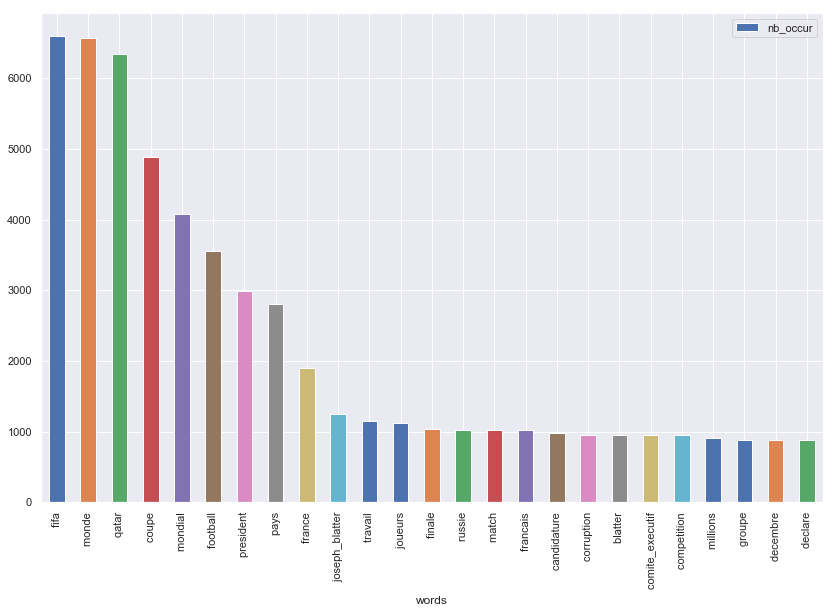

In [63]:
df_most_common_words = most_common(c, 'words', 40)
plot_most_common(df_most_common_words, 'words')

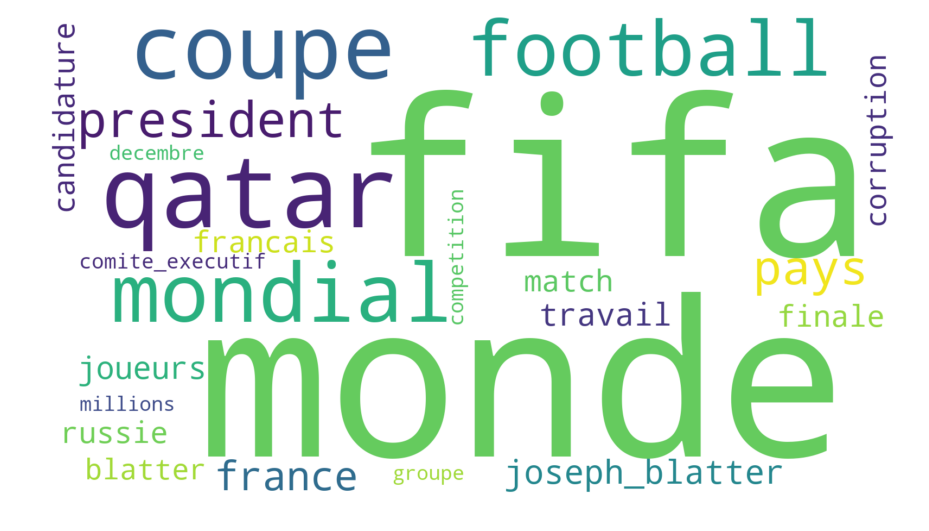

In [64]:
wordcloud(df_most_common_words, 'words')

### 2.2. Bigrams les plus fréquents dans l'ensemble des articles

Un bigram est une séquence de 2 tokens séparés par un "_". Nous avons identifié les bigrams les plus fréquents (ie. les mots que l'on retrouve le plus souvent 2 par 2) avec les algorithmes de nettoyage des données.

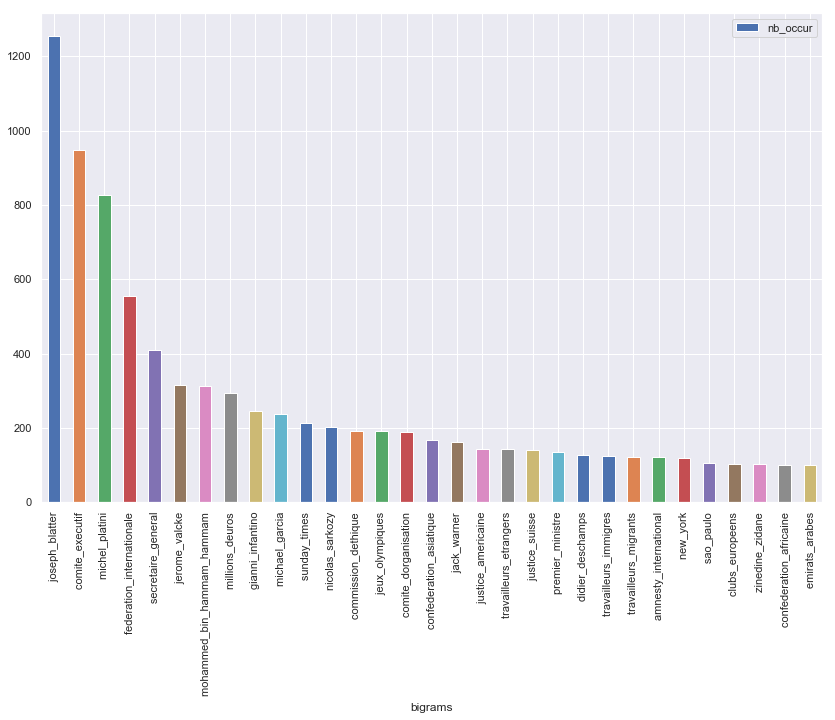

In [65]:
df_most_common_bigrams = most_common(c, 'bigrams', 1000)
plot_most_common(df_most_common_bigrams, 'bigrams')

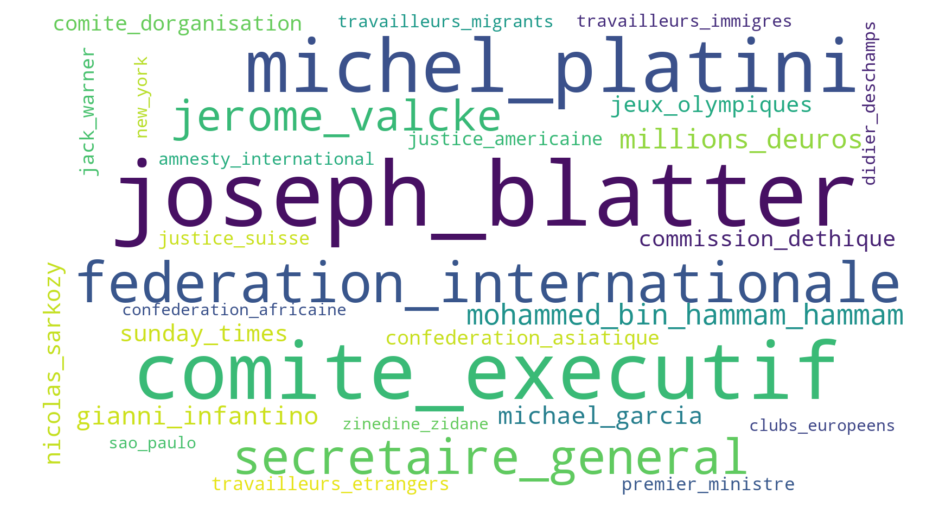

In [66]:
wordcloud(df_most_common_bigrams, 'bigrams')

## 3. Topic Modelling

Ici, nous utilisons les modules de Topic Modelling de la librairie gensim. L'objectif est de dégager des thèmes et mots-clés d'un corpus de textes. Ce qui suit est largement inspiré d'un tutoriel de machinelearningplus : https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?fbclid=IwAR2D9VA-3K8mRUdX0bjujEZtBeodAcyhM3p38aAtNL6SvK9UCVK7BS02b1A

### 3.1. Création du modèle

#### Mise des données au format adéquat

In [67]:
df = df_articles.copy()
df = df.fillna('empty')
data_token = df.content.values.tolist()
data_token = [re.sub(' ', '', w) for w in data_token]

for k in range(len(data_token)):
    if data_token[k] is not 'nan':
        data_token[k] = data_token[k].split(',')
        
data_token = [[word for word in simple_preprocess(str(doc)) if word not in new_stops] for doc in data_token]

#### Création d'un dictionnaire et d'un corpus

In [68]:
id2word = corpora.Dictionary(data_token)
texts = data_token # Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

#### Création du modèle "Latent Dirichlet Allocation" (LDA)

In [69]:
def build_lda_model(nb):

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=nb, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    doc_lda = lda_model[corpus]
    perplexity_lda = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_token, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    model_topics = lda_model.show_topics(formatted=False)
    
    return lda_model, doc_lda, perplexity_lda, coherence_lda, model_topics

In [70]:
# Générer le modèle avec 12 topcis
lda_model, doc_lda, perplexity_lda, coherence_lda, model_topics = build_lda_model(12)

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Etudiant\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + E

### 3.2. Visualisation des résultats

#### Visualisation interactive des topics

In [ ]:
pyLDAvis.enable_notebook() #si on utilise un notebook
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.show(vis)

#### Recherche des topics dominants pour chaque article

In [71]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [72]:
df_topic_sents_keywords = format_topics_sentences(ldamodel = lda_model, corpus = corpus, texts = data_token)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_Index', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#### Topics classés par fréquence

In [73]:
# Mise au bon format
df_dominant_topic_small = df_dominant_topic.copy()
del df_dominant_topic_small['Document_Index']
del df_dominant_topic_small['Topic_Perc_Contrib']
del df_dominant_topic_small['Text']

TCD = pd.pivot_table(df_dominant_topic_small,
                    index=['Dominant_Topic'],
                    aggfunc='count')

df = TCD.merge(df_dominant_topic_small, on='Dominant_Topic', how='left')
df = df.drop_duplicates()
df = df.reset_index(drop = True)
df.columns=['Dominant_Topic', 'Percentage', 'Keywords']
df['Percentage'] = 100*df['Percentage']/np.sum(df['Percentage'])
df = df.sort_values(ascending=False, by='Percentage')

# Table des topics classés par fréquence
df.head()

,Dominant_Topic,Percentage,Keywords
8,8.0,25.951087,"fifa, president, qatar, mondial, football, mon..."
9,9.0,14.504076,"monde, coupe, qatar, football, mondial, pays, ..."
11,11.0,14.028533,"monde, coupe, contre, match, finale, france, d..."
4,4.0,10.292120,"qatar, travail, conditions, mondial, chantiers..."
2,2.0,9.510870,"pays, qatar, projet, millions, dollars, doha, ..."


In [74]:
# Ajout des topics dominants et keywords au dataframe des articles
df_articles['Dominant_Topic'] = df_dominant_topic['Dominant_Topic']
df_articles['Keywords'] = df_dominant_topic['Keywords']

#### Mots les plus fréquents et wordcloud d'un topic

In [75]:
def topic_most_common(topic, nb_w, nb_b):
    dict_ = []
    
    for k in range(len(df_articles)):
        if df_articles.loc[k]['Dominant_Topic'] == topic:
            dict_.append(df_articles.loc[k]['content'])
            
    dict_ = str(dict_).strip('[]')
    dict_ = dict_.replace("'", "")
    dict_ = dict_.split(',')
    c = Counter(dict_)
    
    df_w = most_common(c, 'words', nb_w)
    df_b = most_common(c, 'bigrams', nb_b)
    
    return df_w, df_b

In [76]:
# Pour le topic le plus fréquent (8)
df_w_8 = topic_most_common(8, 20, 500)[0]
df_b_8 = topic_most_common(8, 20, 500)[1]

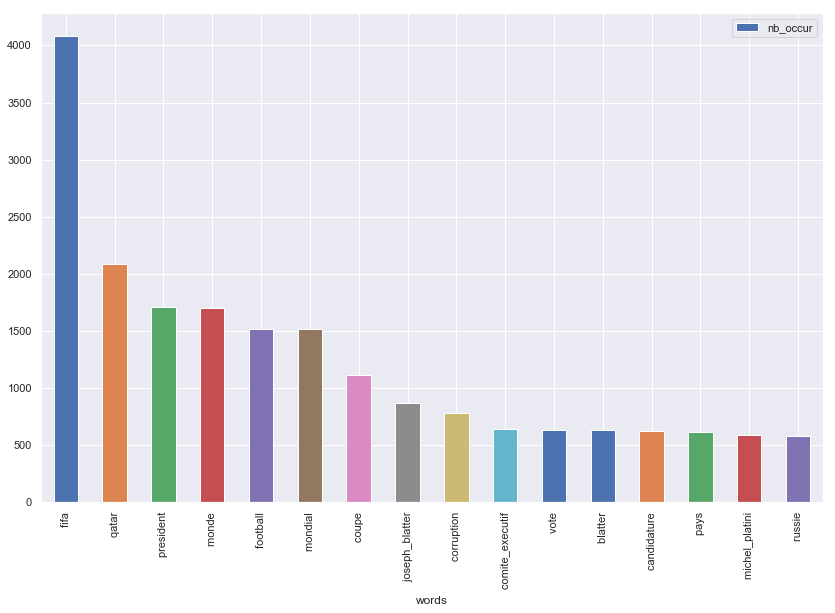

In [77]:
plot_most_common(df_w_8, 'words')

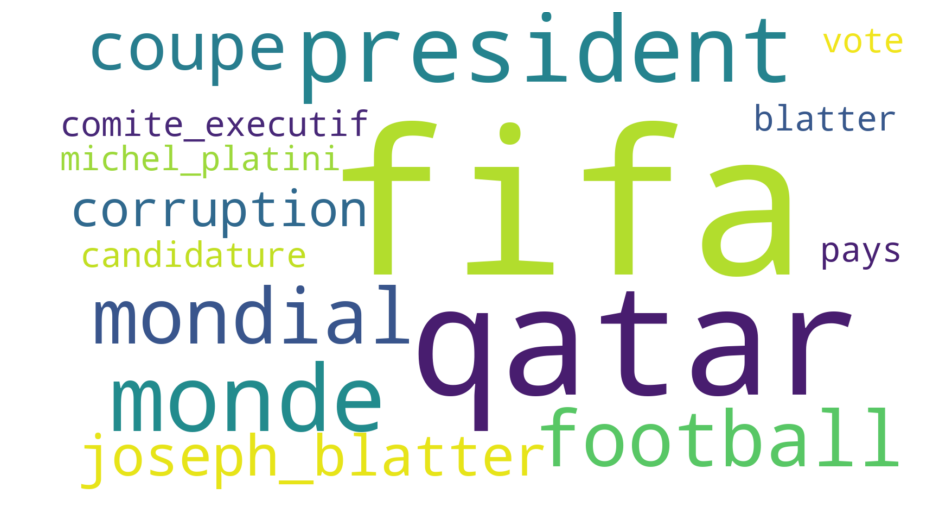

In [78]:
wordcloud(df_w_8, 'words')

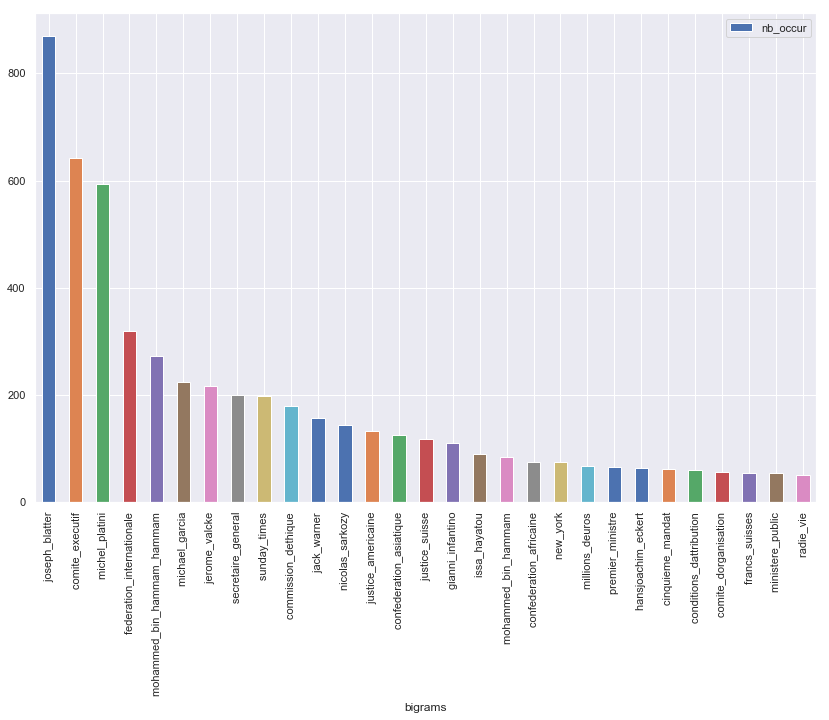

In [79]:
plot_most_common(df_b_8, 'bigrams')

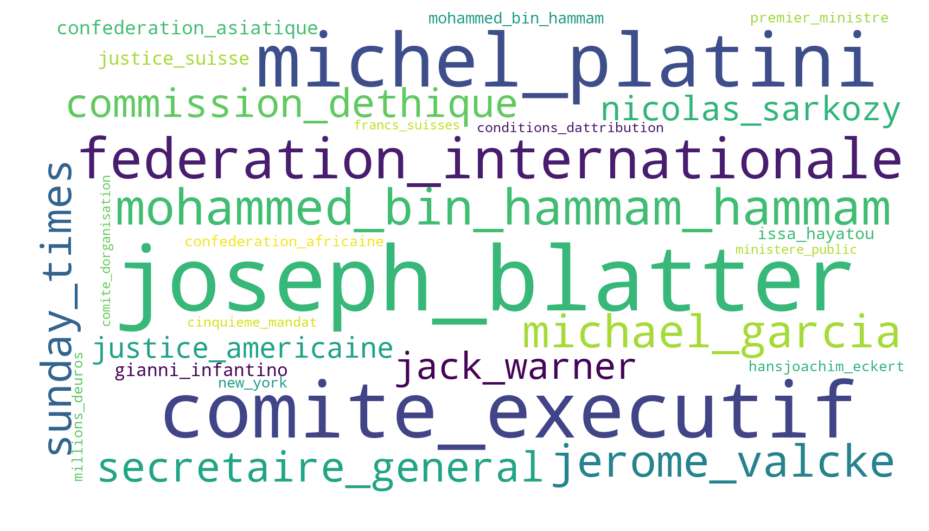

In [80]:
wordcloud(df_b_8, 'bigrams')

## 4. Analyse des sentiments

Nous utilisons ici TexBlob pour analyser les sentiments qui se dégagent des articles. Le module sentiment retourne un tuple (polarité, subjectivité). La polarité est comprise dans l'intervalle [-1, 1] (du plus négatif au plus positif). La subjectivité est comprise dans l'intervalle [0, 1] (du plus objectif au plus subjectif).

In [81]:
df_sentiment = pd.DataFrame(columns=['content','polarity', 'subjectivity', 'polarity_class', 'subjectivity_class'])
df_sentiment['content'] = df_articles['content']
df_sentiment = df_sentiment.fillna('empty')

In [82]:
def sentiment(df_sentiment):
    
    list_content = df_sentiment['content'].tolist()
    
    polarity = []
    subjectivity = []
    polarity_class = [0]*len(list_content)
    subjectivity_class = [0]*len(list_content)
    
    for i in range(len(list_content)):
        if list_content[i] == 'empty':
            polarity.append(0)
            subjectivity.append(0)
            
        else:
            content = list_content[i]
            blob = TextBlob(content, pos_tagger = PatternTagger(), analyzer = PatternAnalyzer())
            polarity.append(blob.sentiment[0])
            subjectivity.append(blob.sentiment[1])
            
    df_sentiment['polarity'] = polarity
    df_sentiment['subjectivity'] = subjectivity
    
    for k in range(len(df_sentiment)):
        p = df_sentiment.loc[k]['polarity']
        
        if p < - 0.05:
            polarity_class[k] = 'negative'
        
        elif p > 0.125:
            polarity_class[k] = 'positive'
            
        else:
            polarity_class[k] = 'neutral'
            
        s = df_sentiment.loc[k]['subjectivity']
        
        if s < 0.2:
            subjectivity_class[k] = 'objective'
        
        elif s > 0.5:
            subjectivity_class[k] = 'subjective'
            
        else:
            subjectivity_class[k] = 'neutral'
            
    df_sentiment['polarity_class'] = polarity_class
    df_sentiment['subjectivity_class'] = subjectivity_class
            
    return(df_sentiment)

In [83]:
df_sentiment = sentiment(df_sentiment)
df_sentiment.head()

,content,polarity,subjectivity,polarity_class,subjectivity_class
0,"deuxla, aimaient, beaucoup, rivalite, joseph_b...",0.119000,0.121500,neutral,objective
1,"devenir, president, fifa, faut, vouloir, titre...",0.090000,0.227273,neutral,neutral
2,"rapport, devait, permettre, connaitre, verite,...",0.085263,0.236842,neutral,neutral
3,"joseph_blatter, devra, compter, nouvel, advers...",0.138611,0.652917,positive,subjective
4,"faire, lumiere, soupcons, corruption, entachan...",0.090319,0.197340,neutral,objective


Nous avons classé les scores de polarité en 3 classes : positif, négatif, neutre ; de même, nous avons classé la subjectivité en 3 classes : obectif, neutre, subjectif.

In [84]:
# Ajout des sentiments au dataframe des articles
df_articles['polarity_class'] = df_sentiment['polarity_class']
df_articles['subjectivity_class'] = df_sentiment['subjectivity_class']

## 5. Relation entre sentiments et topics

Nous essayons désormais de croiser les deux classifications précédentes : sentiments et topics.

In [85]:
df_relation = pd.DataFrame()
df_relation['Dominant_Topic'] = df_articles['Dominant_Topic']
df_relation['polarity_class'] = df_articles['polarity_class']
df_relation['subjectivity_class'] = df_articles['subjectivity_class']

In [86]:
# Tableaux croisés entre sentiments et topics
TCD_polarity = pd.pivot_table(df_relation,
                    index=['Dominant_Topic'],
                    columns=['polarity_class'],
                    aggfunc='count')

TCD_subjectivity = pd.pivot_table(df_relation,
                    index=['Dominant_Topic'],
                    columns=['subjectivity_class'],
                    aggfunc='count')

# Supprimer les topics les moins significatifs
to_del = [0, 1, 3, 5, 6, 7, 10]
TCD_polarity = TCD_polarity.drop(to_del)
TCD_subjectivity = TCD_subjectivity.drop(to_del)

# TCD en % des lignes
TCD_polarity['TOTAL'] = TCD_polarity['subjectivity_class']['negative'] + TCD_polarity['subjectivity_class']['neutral'] + TCD_polarity['subjectivity_class']['positive']
TCD_polarity = 100*TCD_polarity.div(TCD_polarity.iloc[:,-1], axis=0)

TCD_subjectivity['TOTAL'] = TCD_subjectivity['polarity_class']['objective'] + TCD_subjectivity['polarity_class']['neutral'] + TCD_subjectivity['polarity_class']['subjective']
TCD_subjectivity = 100*TCD_subjectivity.div(TCD_subjectivity.iloc[:,-1], axis=0)

In [87]:
TCD_polarity.head()

subjectivity_class                        TOTAL
polarity_class           negative    neutral   positive       
Dominant_Topic                                                
2.0                      2.857143  73.928571  23.214286  100.0
4.0                      3.630363  74.257426  22.112211  100.0
8.0                      3.664921  78.926702  17.408377  100.0
9.0                      6.791569  63.231850  29.976581  100.0
11.0                     7.021792  71.186441  21.791768  100.0

In [88]:
TCD_subjectivity.head()

polarity_class                        TOTAL
subjectivity_class        neutral  objective subjective       
Dominant_Topic                                                
2.0                     31.785714  67.142857   1.071429  100.0
4.0                     32.343234  65.346535   2.310231  100.0
8.0                     23.036649  75.130890   1.832461  100.0
9.0                     38.407494  52.224824   9.367681  100.0
11.0                    44.794189  52.300242   2.905569  100.0

Le topic 9 (monde, coupe, qatar, football, mondial, pays, hiver, jouer, decembre) est moins neutre : il est considéré comme plus subjectif et avec des opinions plus affirmées.

## 6. Analyse des articles sur 2 personnes : Blatter et Platini

In [89]:
df_articles_persons = pd.DataFrame.from_csv(path + 'articles_persons_trait.csv', sep=';') # import de la table des articles/personnes

C:\Users\Etudiant\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [90]:
list_blatter = [0]*len(df_articles)
list_platini = [0]*len(df_articles)

for k in range(len(df_articles_persons)):
    pers = df_articles_persons.loc[k]['id_pers']
    art = df_articles_persons.loc[k]['id_article']
    
    if pers == 148:
        list_blatter[art] = 1
    
    if pers == 204:
        list_platini[art] = 1    
     
        
df_articles['concerne_blatter'] = list_blatter # ajout d'une colonne 'concerne_blatter' (bool) au dataframe des articles
df_articles['concerne_platini'] = list_platini # ajout d'une colonne 'concerne_platini' (bool) au dataframe des articles

In [92]:
somme_list = [list_blatter[i] + list_platini[i] for i in range(len(list_blatter))]
dict([(k, somme_list.count(k)) for k in set(somme_list)])

{0: 2066, 1: 551, 2: 327}

327 articles concernent à la fois Blatter et Platini, 551 concernent un des 2.

#### Mots les plus fréquents et Wordcloud concernant une personne

In [93]:
def pers_most_common(concerne_nom, nb_w, nb_b):
    dict_ = []
    
    for k in range(len(df_articles)):
        if df_articles.loc[k][concerne_nom] == 1:
            dict_.append(df_articles.loc[k]['content'])
            
    dict_ = str(dict_).strip('[]')
    dict_ = dict_.replace("'", "")
    dict_ = dict_.split(',')
    c = Counter(dict_)
    
    df_w = most_common(c, 'words', nb_w)
    df_b = most_common(c, 'bigrams', nb_b)
    
    return df_w, df_b

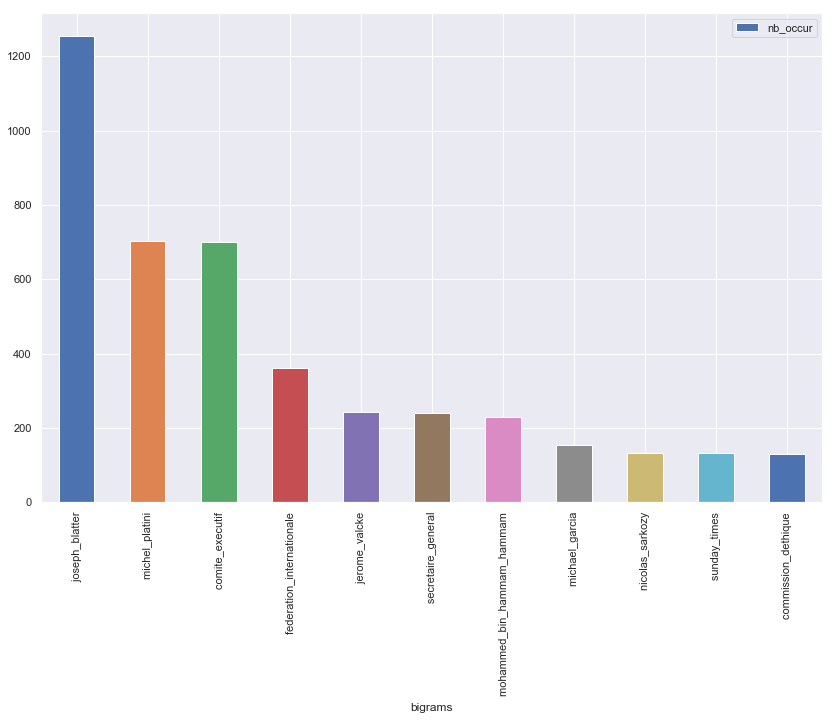

In [94]:
df_w_blatter = pers_most_common('concerne_blatter', 15, 200)[0]
df_b_blatter = pers_most_common('concerne_blatter', 15, 200)[1]
plot_most_common(df_b_blatter, 'bigrams') # le seul pertinent

Nous avons regardé les mots les plus fréquents pour les articles conernant Blatter et Platini. Le résultat le plus pertinent est présenté ci-dessus : les articles concernant Blatter traitent essentiellement des 2 personnages, de la FIFA et d'autres personnages importants impliqués dans l'organisation de la coupe du Monde.

Nous avons également analysé rapidement la polarité et subjectivité des articles concernant Blatter et Platini à l'aide de tableaux croisés dynamiques sur Excel, mais rien de significatif ne s'est dégagé.

## 7. Analyse des articles de Courrier International

Courrier International est une source un peu particulière si on la compare à nos autres sources qui sont plutôt des journaux / sites français grand public. Courrier International publie des articles tirés de la presse étrangère et nous permet d'avoir des opinions venues du monde entier.

Nous avons très peu d'articles (54) mais il nous a semblé pertinent de tenter de faire quelques analyses simples sur ce corpus.

In [102]:
df_articles_countries = pd.DataFrame.from_csv(path + '\\POUR_BD\\articles_countries.csv', sep=';')
df_countries = pd.DataFrame.from_csv(path + '\\POUR_BD\\countries_list.csv', sep=';')

countries_a = [0]*len(df_articles_countries)

for k in range(len(df_articles_countries)):
    countries_a[k] = df_countries.loc[df_articles_countries.loc[k]['id_country']]['country']

df_articles['country'] = countries_a
df_courrierint = df_articles.loc[:53] 
to_del = ['source', 'url', 'date', 'theme', 'title', 'subtitle', 'content', 'abo', 'content_type', 'Dominant_Topic', 'Keywords', 'concerne_blatter', 'concerne_platini', 'year']
df_courrierint = df_courrierint.drop(to_del, axis=1)
df_courrierint.head()

C:\Users\Etudiant\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
C:\Users\Etudiant\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


,polarity_class,subjectivity_class,country
0,neutral,objective,Allemagne
1,neutral,neutral,Pays-Bas
2,neutral,neutral,Royaume-Uni
3,positive,subjective,Royaume-Uni
4,neutral,objective,Royaume-Uni


#### Répartition des pays sources

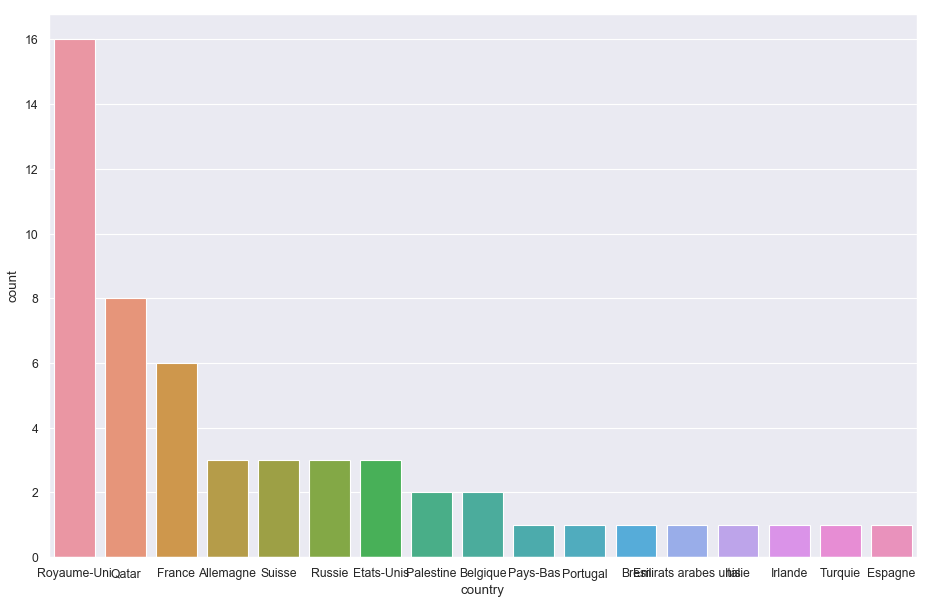

In [103]:
plt.figure(figsize = (14, 9), dpi = 80)
sns.set(style = 'darkgrid')
ax = sns.countplot(x = 'country', data = df_courrierint, order = df_courrierint['country'].value_counts().index)

In [104]:
to_keep = ['France', 'Qatar', 'Royaume-Uni'] # ne garder que les 3 pays les plus représentés
id_to_keep = []

for k in range(len(df_courrierint)):
    if df_courrierint.loc[k]['country'] not in to_keep:
        df_courrierint = df_courrierint.drop(k)

#### Croisement entre pays source et polarité

In [105]:
pd.pivot_table(df_courrierint,
               index=['country'],
               columns=['polarity_class'],
               aggfunc='count')

subjectivity_class                 
polarity_class           negative neutral positive
country                                           
France                        NaN     4.0      2.0
Qatar                         NaN     4.0      4.0
Royaume-Uni                   2.0    10.0      4.0

Qatar : 8 articles dont aucun négatif, 4 positifs et 4 neutres ; RU : 16 articles dont 10 neutres, 4 positifs, 2 négatifs ; France : 8 articles dont aucun négatif, 2 positifs et 4 neutres.

#### Croisement entre pays source et subjectivité

In [106]:
pd.pivot_table(df_courrierint,
               index=['country'],
               columns=['subjectivity_class'],
               aggfunc='count')

polarity_class                     
subjectivity_class        neutral objective subjective
country                                               
France                        NaN       5.0        1.0
Qatar                         4.0       4.0        NaN
Royaume-Uni                   6.0       6.0        4.0

Qatar : 8 articles dont aucun subjectif, 4 objectifs et 4 neutres ; RU : 16 articles dont 6 neutres, 6 objectifs, 4 subjectifs ; France : 8 articles dont aucun neutre, 5 objectifs et 1 subjectif.